In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
import torch
import numpy as np
import pandas as pd
from diffusers.utils import make_image_grid
from transformers import (
    SamModel,
    SamProcessor,
    AutoProcessor,
    LlavaForConditionalGeneration,
)
from PIL import Image

from src.eunms import Model_Type, Scheduler_Type
from src.utils.enums_utils import get_pipes
from src.config import RunConfig
from main import run as invert

from attention_maps_utils_by_timesteps import (
    get_attn_maps,
    cross_attn_init,
    register_cross_attention_hook,
    set_layer_with_name_and_path,
    preprocess,
    visualize_and_save_attn_map,
)

/cortex/users/yairshp/miniconda3/envs/renoise_inversion/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/cortex/users/yairshp/miniconda3/envs/renoise_inversion/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/cortex/users/yairshp/miniconda3/envs/renoise_inversion/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/cortex/users/yairshp/miniconda3/envs/renoise_inversion/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarnin

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_type = Model_Type.SDXL_Turbo
scheduler_type = Scheduler_Type.EULER
pipe_inversion, pipe_inference = get_pipes(
    model_type, scheduler_type, device=device, is_mask_edit=True
)

Keyword arguments {'safety_checker': None} are not expected by StableDiffusionXLImg2ImgMaskEditPipeline and will be ignored.
Loading pipeline components...:  86%|████████▌ | 6/7 [00:01<00:00,  7.05it/s]/cortex/users/yairshp/miniconda3/envs/renoise_inversion/lib/python3.11/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  5.42it/s]


In [4]:
config = RunConfig(
    model_type=model_type,
    scheduler_type=scheduler_type,
    noise_regularization_lambda_kl=0.9,
    noise_regularization_lambda_ac=90,
    num_inversion_steps=4,
    num_inference_steps=4,
)

In [5]:
data_path = (
    "/home/lab/yairshp/projects/insert_object/benchmark/object_placement_images.csv"
)
data = pd.read_csv(data_path, dtype={"bg_img_id": str, "ref_img_id": str})
open_images_path = "/cortex/data/images/OpenImagesV6/images"
cocoee_path = "/cortex/data/images/COCOEE/test_bench/Ref_3500"

# open_images dataset is used for bg_images. add a column of the path to the image (the path is the <open_images_path>/<image_id>.jpg)
data["bg_img_path"] = data["bg_img_id"].apply(lambda x: f"{open_images_path}/{x}.jpg")

# cocoee dataset is used for ref_images. add a column of the path to the image (the path is the <cocoee_path>/<image_id>_ref.png)
data["ref_img_path"] = data["ref_img_id"].apply(lambda x: f"{cocoee_path}/{x}_ref.png")

In [6]:
my_bg_images = [
    "/home/lab/yairshp/projects/insert_object/benchmark/bed.jpeg",
    "/home/lab/yairshp/projects/insert_object/benchmark/desk.jpeg",
    "/home/lab/yairshp/projects/insert_object/benchmark/cabinet.jpeg",
    "/home/lab/yairshp/projects/insert_object/benchmark/face.jpg",
]

my_object_images = [
    "/home/lab/yairshp/projects/insert_object/benchmark/objects/pillow/pillow.jpeg",
    "/home/lab/yairshp/projects/insert_object/benchmark/objects/plant/plant.jpg",
    "/home/lab/yairshp/projects/insert_object/benchmark/objects/vase/vase.jpeg",
    "/home/lab/yairshp/projects/insert_object/benchmark/objects/hat/hat.png",
]

In [7]:
bg_images = list(data["bg_img_path"])
bg_images.extend(my_bg_images)
ref_images = list(data["ref_img_path"])
ref_images.extend(my_object_images)

In [8]:
def preprocess_image(image_path):
    image = Image.open(image_path)
    return image.convert("RGB").resize((512, 512))


bg_images = [preprocess_image(image) for image in bg_images]
ref_images = [preprocess_image(image) for image in ref_images]

In [9]:
llava_model = LlavaForConditionalGeneration.from_pretrained(
    "llava-hf/llava-1.5-7b-hf"
).to(device)
llava_processor = AutoProcessor.from_pretrained("llava-hf/llava-1.5-7b-hf")

Loading checkpoint shards: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [10]:
def get_prompts(processor, model, images, object_names=None):
    if object_names is None:
        propmt = "USER: <image>\nWhat's in the image (answer in shortest way possible)? ASSISTANT:"
        prompts = [propmt for _ in range(len(images))]
    else:
        prompts = [
            f"USER: <image>\nWhat's in the image that a {ref} can be on (answer in shortest way possible)? ASSISTANT:"
            for ref in object_names
        ]
    answers = []
    for prompt, image in zip(prompts, images):
        inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)
        generate_ids = model.generate(**inputs, max_new_tokens=15)
        answer = processor.batch_decode(
            generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False
        )[0]
        # the answer should be the string after the last colon
        answer = answer.split(":")[-1].strip()
        answers.append(answer)
    return answers


def get_edit_prompts(inversion_prompts, objects):
    edit_prompts = []
    for inversion_prompt, object in zip(inversion_prompts, objects):
        edit_prompts.append(f"a {inversion_prompt} and a {object}".lower())
    return edit_prompts

In [11]:
object_names = get_prompts(llava_processor, llava_model, ref_images)
# inversion_prompts = get_prompts(llava_processor, llava_model, bg_images, object_names)
# object_names = get_prompts(blip_processor, blip_model, ref_images)
# inversion_prompts = get_prompts(blip_processor, blip_model, bg_images, object_names)
# edit_prompts = get_edit_prompts(inversion_prompts, object_names)
inversion_prompts = ["an image" for _ in range(len(bg_images))]
edit_prompts = [f"an image of a {o.lower()}" for o in object_names]

In [12]:
for inversion_prompt, object_name, edit_prompt in zip(
    inversion_prompts, object_names, edit_prompts
):
    print(f"Prompt: {inversion_prompt} + {object_name} -> {edit_prompt}")

Prompt: an image + Glass -> an image of a glass
Prompt: an image + Glass -> an image of a glass
Prompt: an image + Pepsi -> an image of a pepsi
Prompt: an image + Cat -> an image of a cat
Prompt: an image + Vase -> an image of a vase
Prompt: an image + Orange -> an image of a orange
Prompt: an image + Glass -> an image of a glass
Prompt: an image + Plant -> an image of a plant
Prompt: an image + Suitcase -> an image of a suitcase
Prompt: an image + Teddy bear -> an image of a teddy bear
Prompt: an image + Dog -> an image of a dog
Prompt: an image + Glass -> an image of a glass
Prompt: an image + Pillow -> an image of a pillow
Prompt: an image + Plant -> an image of a plant
Prompt: an image + Vase -> an image of a vase
Prompt: an image + Hat -> an image of a hat


In [13]:
def invert_images(images, prompts):
    inv_latents = []
    noises = []
    all_latents = []
    for image, prompt in zip(images, prompts):
        _, inv_latent, noise, latetns_per_timestep = invert(
            image,
            prompt,
            config,
            pipe_inversion=pipe_inversion,
            pipe_inference=pipe_inference,
            do_reconstruction=False,
        )
        inv_latents.append(inv_latent)
        noises.append(noise)
        all_latents.append(latetns_per_timestep)
    return inv_latents, noises, all_latents

In [14]:
inv_latents, noises, all_latents = invert_images(bg_images, inversion_prompts)

Inverting...


  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


Inverting...


100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


Inverting...


100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


Inverting...


100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


Inverting...


100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


Inverting...


100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


Inverting...


100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


Inverting...


100%|██████████| 4/4 [00:04<00:00,  1.06s/it]


Inverting...


100%|██████████| 4/4 [00:04<00:00,  1.06s/it]


Inverting...


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Inverting...


100%|██████████| 4/4 [00:04<00:00,  1.12s/it]


Inverting...


100%|██████████| 4/4 [00:04<00:00,  1.13s/it]


Inverting...


100%|██████████| 4/4 [00:04<00:00,  1.20s/it]


Inverting...


100%|██████████| 4/4 [00:04<00:00,  1.14s/it]


Inverting...


100%|██████████| 4/4 [00:04<00:00,  1.13s/it]


Inverting...


100%|██████████| 4/4 [00:04<00:00,  1.15s/it]


In [15]:
# cross_attn_init()
# pipe_inference.unet = set_layer_with_name_and_path(pipe_inference.unet)
# pipe_inference.unet = register_cross_attention_hook(pipe_inference.unet)

In [20]:
def get_attn_map(edit_prompt):
    attn_maps = get_attn_maps()
    attn_map = preprocess(attn_maps[-1], 512, 512)
    attn_map_img = visualize_and_save_attn_map(
        attn_map, pipe_inference.tokenizer, edit_prompt, edit_prompt.split()[-1].lower()
    )
    return attn_map_img


def reset_attn_maps():
    attn_maps = get_attn_maps()
    attn_maps.clear()


def get_edit_images_and_attn_maps(
    inv_latents, noises, inversion_prompts, edit_prompts, attn_maps
):
    edit_images = []
    last_timestep_attn_maps = []
    for (
        inv_latent,
        noise,
        image_latents,
        attn_map,
        inversion_prompt,
        edit_prompt,
    ) in zip(
        inv_latents, noises, all_latents, attn_maps, inversion_prompts, edit_prompts
    ):
        pipe_inference.scheduler.set_noise_list(noise)
        pipe_inference.cfg = config
        # image_latents_input = image_latents[1:]
        image_latents_input = image_latents[:-1]
        image_latents_input.reverse()
        image_latents_input = (
            torch.stack(image_latents_input).squeeze(1).unsqueeze(0).half()
        )
        mask_image = (
            torch.tensor(np.array(attn_map)).to(device).unsqueeze(0).half() / 255.0
        )
        mask_image = (mask_image - mask_image.min()) / (
            mask_image.max() - mask_image.min()
        )
        edit_image = pipe_inference(
            prompt=edit_prompt,
            image_latents=image_latents_input,
            mask_image=mask_image,
            mask_weight=0.75,
            num_inference_steps=config.num_inference_steps,
            negative_prompt=inversion_prompt,
            image=inv_latent,
            strength=config.inversion_max_step,
            denoising_start=1.0 - config.inversion_max_step,
            guidance_scale=config.guidance_scale,
        ).images[0]
        edit_images.append(edit_image)
        # last_timestep_attn_maps.append(get_attn_map(edit_prompt))
        # reset_attn_maps()

    return edit_images, last_timestep_attn_maps

In [21]:
attn_maps_path = "attn_maps"
attn_maps = [Image.open(f"{attn_maps_path}/{i}.jpg") for i in range(16)]

In [22]:
edit_images, last_timestep_attn_maps = get_edit_images_and_attn_maps(
    inv_latents, noises, inversion_prompts, edit_prompts, attn_maps
)

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 19.65it/s]


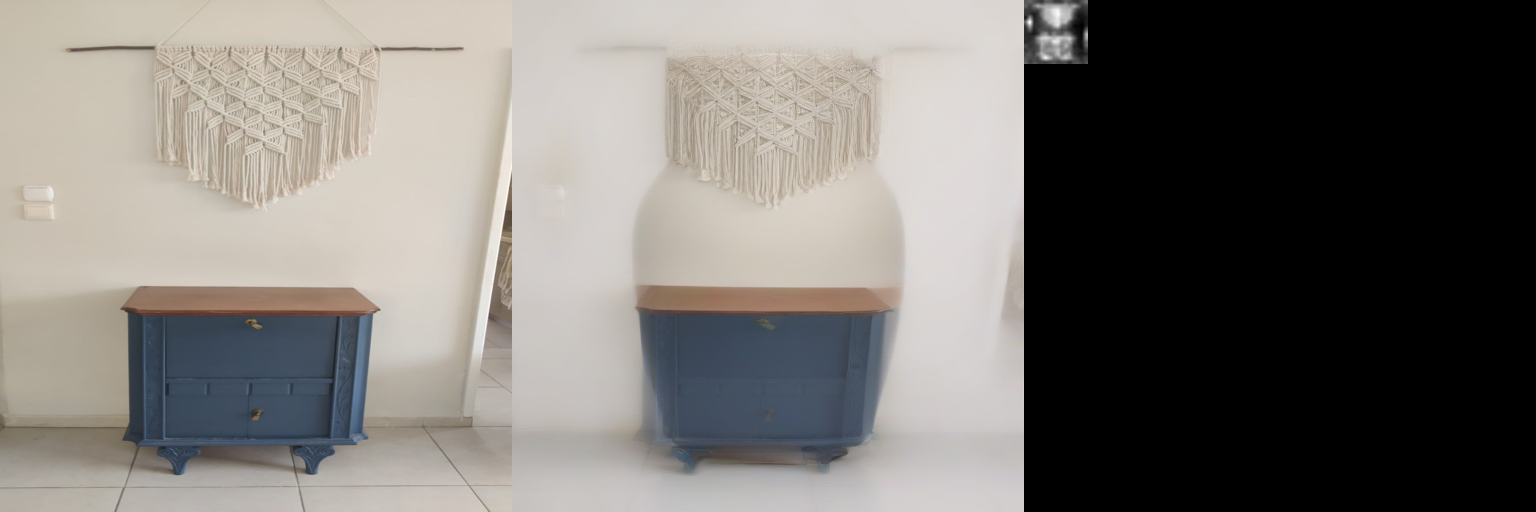

In [23]:
i = 14
make_image_grid([bg_images[i], edit_images[i], attn_maps[i]], 1, 3)